In [1]:
import pandas as pd
import numpy as np
import os
import xarray as xr
from importlib import reload

from sklearn.model_selection import train_test_split
from sklearn import linear_model

import plotly.express as px
import sys

import sys
sys.path.append('..')

# from src import polygon_data, feeds
# from lib import metrics, paths, calcs, ys, utils, posttrade

import make_market

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
Q = 10
x0 = 9
b = 2


def cost(q_yes, q_no, b=1):
    return b * np.log(np.exp(q_yes / b)+ np.exp(q_no / b))
    
def qyes_from_pq(p, Q, b=1):
    x = np.sqrt((p/(1-p) * np.exp(Q/b)))
    return (np.log(x) * b).item()
    
def qno_from_pq(p,Q,b=1):
    return Q - qyes_from_pq(p,Q,b=b)

def prob(q_yes, q_no, b=1):
    return np.exp(q_yes/b) / (np.exp(q_no/b) + np.exp(q_yes/b))


In [3]:


q_no_init = 3
q_yes_init = 7

q_yes = np.linspace(0,10, 1000)
q_no = np.linspace(0, 10, 1000)

initial_cost = make_market.cost(q_yes=q_yes_init, q_no=q_no_init)
dcost_yes = make_market.cost(q_yes=q_yes, q_no=q_no_init) - initial_cost
dcost_no = make_market.cost(q_yes=q_yes_init, q_no=q_no) - initial_cost


In [113]:
Q = 20000
p = .635
B = 100000

dq_yes = np.linspace(0, 3*B, 1000)
dq_no = np.linspace(0, 3*B, 1000)

q_yes_init = make_market.qyes_from_pq(p,Q,b=B)
q_no_init = make_market.qno_from_pq(p,Q,b=B)
q_no_init2 = make_market.qyes_from_pq(1-p,Q,b=B)
q_yes_init, q_no_init, q_no_init2

(37686.38226551, -17686.38226551, -17686.382265510012)

In [114]:
reload(make_market)
# make_market.create_order_price_schedule(p, 2

<module 'make_market' from '/Users/mrthekid/git/eterniscollab/notebooks/../make_market.py'>

In [115]:
reload(make_market)
yes_schedule, no_schedule = make_market.create_order_price_schedule(p=p, half_spread_bps=5, max_order_bps =5000, num_orders=5)
# yes_schedule = [.71,  .75, .77,.8, .85,.9]
cum_yes_order_cost = make_market.yes_order_schedule(p, Q, yes_schedule,b=B)['cost_cumulative'].values

# no_schedule = [.69, .65, .6, .5, .3]
cum_no_order_cost = make_market.no_order_schedule(p, Q, no_schedule, b=B)['cost_cumulative'].values

lo_prices = np.concatenate([no_schedule[::-1], yes_schedule])
lo_cumsum = np.concatenate([cum_no_order_cost[::-1], cum_yes_order_cost])

In [116]:
cum_no_order_cost

array([5.00000e+01, 1.25375e+04, 2.50250e+04, 3.75125e+04, 5.00000e+04])

In [108]:
no_schedule

[0.6996500874854185,
 0.6175162198022538,
 0.5450242750477934,
 0.4810423611002429,
 0.42457146179884336]

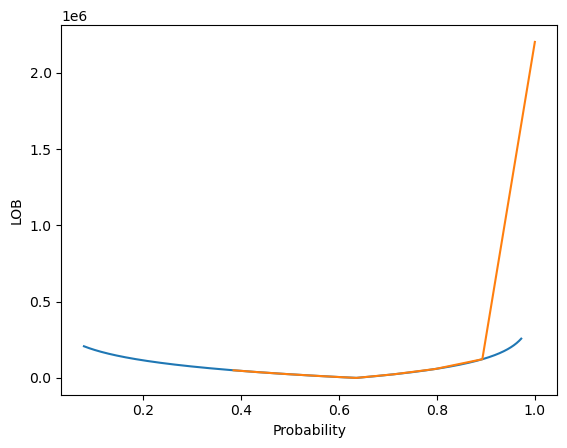

In [117]:
q_yes = dq_yes + q_yes_init
q_no = (dq_no + q_no_init)[::-1]

prob_yes = make_market.prob(q_yes=q_yes, q_no=q_no_init,b=B)
prob_no = make_market.prob(q_yes=q_yes_init, q_no=q_no,b=B)

initial_cost = cost(q_yes=q_yes_init, q_no=q_no_init, b=B)


dcost_yes = make_market.dcost_yes(dq_yes, p, Q, b=B)
dcost_no = make_market.dcost_no(dq_no[::-1], p, Q, b=B)


prob_arr = np.concatenate([prob_no, prob_yes])
cost_arr = np.concatenate([dcost_no, dcost_yes])

plt.plot(prob_arr, cost_arr)
plt.plot(lo_prices, lo_cumsum)
plt.xlabel("Probability")
plt.ylabel("LOB")
plt.show()